![](https://i.imgur.com/sWyuy4Y.jpg)

In this notebook, I'll use the dataset "StackSample: 10% of Stack Overflow Q&A", I'll only use the questions and the tags. 
I will implement a tag suggestion system. I'll both try machine learning models and deep learning models like Word2Vec. I'll then compare the performance of both approaches. 

This notebook will be divided in 2 parts:
* PART 1 : Cleaning data and EDA
* PART 2 : Classical classifiers implemented (SGC classifier, MultiNomial Naive Bayes Classifier, Random Forest Classfier, ...


**PART 1: Cleaning Data and Exploratory Data Analysis**

**1.1 Setting up the dataset for later training**

Importing useful libraries at first

In [0]:
!pip install -q xgboost

In [0]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss, zero_one_loss
from sklearn.cluster import KMeans
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
import xgboost as xgb
from pandas import Series,DataFrame
import pandas as pd
from sklearn.externals import joblib #jbolib模块


import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Setting a random seed in order to keep the same random results each time I run the notebook
np.random.seed(seed=11)

In [0]:
import os 
print(os.listdir("/content/drive/My Drive/CIS 520/final"))

['input', 'model', 'yuhan.ipynb']


In [0]:
# Importing the database 

df = pd.read_csv("/content/drive/My Drive/CIS 520/final/input/Questions.csv", encoding="ISO-8859-1")

In [0]:
df.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [0]:
tags = pd.read_csv("/content/drive/My Drive/CIS 520/final/input/Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})

In [0]:
tags.head(5)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
Id              1264216 non-null int64
OwnerUserId     1249762 non-null float64
CreationDate    1264216 non-null object
ClosedDate      55959 non-null object
Score           1264216 non-null int64
Title           1264216 non-null object
Body            1264216 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [0]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
Id     int64
Tag    object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


First, what I want to do is to merge both dataframes. In order to do that, I'll have to group tags by the id of the post since a post can have multiple tags. I'll just use the groupeby function and then merge the dataframes on the id. 

In [0]:
tags['Tag'] = tags['Tag'].astype(str)

In [0]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [0]:
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [0]:
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [0]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [0]:
grouped_tags_final.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [0]:
df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [0]:
df = df.merge(grouped_tags_final, on='Id')

In [0]:
df.head(5)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


Now, I'll take only quesions witha score greater than 5. I'm doing that for 2 reasons:
* 1- I'll require less computational resources from kaggle.
* 2- The posts will probably be with a better quality and will be better tagged since they have lots of upvotes. 


In [0]:
new_df = df[df['Score']>5]

**1.2 Cleaning Data**

Text(0.5, 1.0, 'Ratio of missing values per columns')

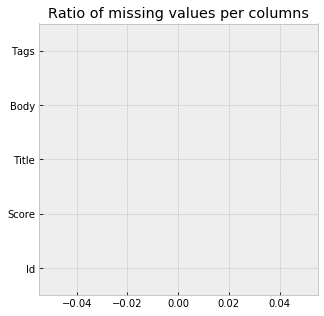

In [0]:
plt.figure(figsize=(5, 5))
new_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [0]:
print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 0


This is a very good dataset since there are no missing valeus or dupplicate values. 

In [0]:
new_df.drop(columns=['Id', 'Score'], inplace=True)

Now we only need 3 columns: Body, Title and Tags. 

**1.2.1 Tags**

Let's do some cleaning on the tags' column. Furthermore, I decided to keep the 100 most popular tags because I'll be easier to predict the right tag from 100 words than from 14,000 and because we want to keep macro tags and not be too specific since it's only a recommendation for a post, the user can add more specific tags himself. 

In [0]:
new_df.head(5)

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [0]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())

In [0]:
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]

In [0]:
len(all_tags)

224129

In [0]:
my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

14883

In [0]:
flat_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(50)
tags_features = [word[0] for word in frequencies_words]

In [0]:
tags_features

['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 '.net',
 'ios',
 'html',
 'css',
 'c',
 'iphone',
 'objective-c',
 'ruby-on-rails',
 'sql',
 'asp.net',
 'mysql',
 'ruby',
 'r',
 'git',
 'asp.net-mvc',
 'linux',
 'sql-server',
 'node.js',
 'angularjs',
 'django',
 'performance',
 'algorithm',
 'string',
 'xcode',
 'arrays',
 'wpf',
 'eclipse',
 'haskell',
 'windows',
 'scala',
 'multithreading',
 'json',
 'c++11',
 'regex',
 'visual-studio',
 'html5',
 'osx',
 'swift',
 'database',
 'unit-testing',
 'spring',
 'xml']

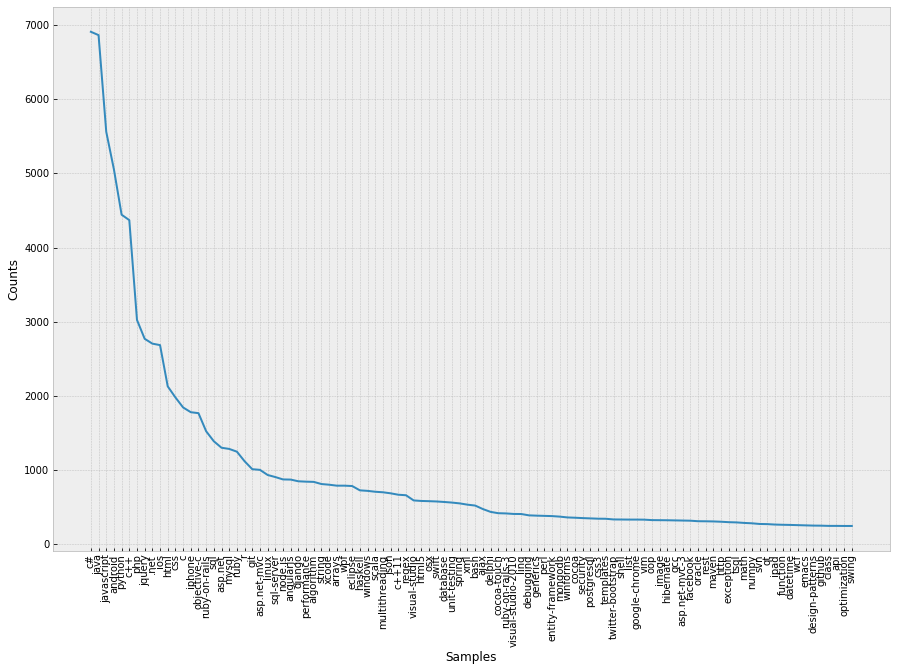

In [0]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [0]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [0]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [0]:
new_df.shape

(72950, 3)

In [0]:
new_df.dropna(subset=['Tags'], inplace=True)

In [0]:
new_df.shape

(58872, 3)

We are here loosing 10000 rows but the it's for the greater good. 

**1.2.2 Body**

In the next two columns: Body and Title, I'll use lots of text processing:
* Removing html format 
* Lowering text
* Transforming abbreviations 
* Removing punctuation (but keeping words like c# since it's the most popular tag)
* Lemmatizing words
* Removing stop words

In [0]:
# Converting html to text in the body

new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [0]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [0]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x)) 

In [0]:
token=ToktokTokenizer()

In [0]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [0]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [0]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))




In [0]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x)) 

In [0]:
new_df['Body'][2]

'has anyone got experience creating sql-based asp.net site-map providers i have got the default xml file websitemap working properly with my menu and sitemappath controls but i will need a way for the users of my site to create and modify pages dynamically i need to tie page viewing permissions into the standard asp.net membership system as well'

In [0]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [0]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [0]:
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x)) 

**1.2.3 Title**

In [0]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x)) 

**1.3 EDA**

Here I'll just use some LDA to see if shows any paterns in words and the main topics.  

In [0]:
no_topics = 20

In [0]:
text = new_df['Body']

In [0]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000)

In [0]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [0]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [0]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

--------------------------------------------
Topic 0:
function var script div html consolelog jquery id input javascript
--------------------------------------------
--------------------------------------------
Topic 1:
request password user email send server url login response username
--------------------------------------------
--------------------------------------------
Topic 2:
array item list li items arr val element loop ul
--------------------------------------------
--------------------------------------------
Topic 3:
use web service json application api server google asp.net scala
--------------------------------------------
--------------------------------------------
Topic 4:
string character line print match file text output like str
--------------------------------------------
--------------------------------------------
Topic 5:
file git ios commit branch upload device devices directory use
--------------------------------------------
----------------------------------

It's a bit disappointing but I'm certain that it can be done better. 

**PART 2: Classical classifiers**

**2.1 Data preparation**

Now our data is almost ready to be put into a classifier. I just need to:
* Binarize the tags
* Use a TFIDF for body and Title
The parameters in the TFIDF are very important for the performance of our tags since we don't want him to delete words like c# or.net. To do that we need to use the following pattern : token_pattern=r"(?u)\S\S+"

In [0]:
X1 = new_df['Body']
X2 = new_df['Title']
y = new_df['Tags']

In [0]:
# -- binary multiclass --
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

# -- integer multiclass --
# tags preprocessing 
y_ls = []
for e in y.values:
    y_ls.append(str(e))

# print(len(y_ls))    
lbl_enc = preprocessing.LabelEncoder()
y_int = lbl_enc.fit_transform(y_ls)

# -- test number of tags --
data = {'val': (y_ls)}
df =  DataFrame(data)
print(df.val.nunique())
print(y_int.max())

1973
1972


In [0]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [0]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

In [0]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [0]:
# -- binary multiclass --
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.1, random_state = 1) # Do 80/20 split

Now it's finally ready. 

**2.2 One vs Rest**

2.2.1 Define different loss for performance evaluation, including:

     1. multi class log loss

     2. Jacard score

     3. Hamming loss

     4. Precision, recall

In [0]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """对数损失度量（Logarithmic Loss  Metric）的多分类版本。
    :param actual: 包含actual target classes的数组
    :param predicted: 分类预测结果矩阵, 每个类别都有一个概率
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def hamming_loss_percent(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    loss = hamming_loss(y_true, y_pred)
    
    return loss*100

def accuracy(tags_predict, tags_true, prob_threshold):
    '''
    tag_dim indicate the num of tags
    :param tags_predict: shape [batch_size, tag_dim]
    :param tags_true: shape [batch_size, tag_dim]
    :param prob_threshold: float from 0 to 1
    :return: acc: the average accuracy of predictions for batch size examples
    '''
    # make sure it's numpy
    tags_predict = np.array(tags_predict).astype(float)
    tags_true = np.array(tags_true).astype(float)
    if tags_predict.ndim>1:
        N = tags_predict.shape[0]
    else:
        N=1
    # print('N:', N)

    tags_predict_mix = np.where(tags_predict >= prob_threshold, 1, tags_predict)  # mix of prob and 1
    tags_predict_binary = np.where(tags_predict >= prob_threshold, 1, 0) # 0 or 1

    # right = np.sum(tags_predict_binary*tags_true)
    # wrong = np.sum(tags_predict_mix)-right

    right = np.sum(tags_predict_binary * tags_true)
    wrong = np.sum(tags_predict_binary) - right
    # print('right', right)
    # print('wrong', wrong)

    acc = (right - wrong)/N
    if acc < 0:
        acc = 0
    return acc


def evaluation(tags_predict, tags_true, prob_threshold, name_type):
    '''
    Give evaluation of the prediction for true tags
    :param tags_predict: shape [batch_size, tag_dim]
    :param tags_true: shape [batch_size, tag_dim]
    :param prob_threshold: float from 0 to 1
    :param name_type: str, evaluation type: 'precision', 'recall'('sensitivity')
    :return: eval: the average evaluation of predictions for batch size examples
    '''
    # make sure it's numpy
    tags_predict = np.array(tags_predict).astype(float)
    tags_true = np.array(tags_true).astype(float)
    if tags_predict.ndim > 1:
        N = tags_predict.shape[0]
    else:
        N = 1

    tags_predict_mix = np.where(tags_predict >= prob_threshold, 1, tags_predict)  # mix of prob and 1
    tags_predict_binary = np.where(tags_predict >= prob_threshold, 1, 0)  # 0 or 1

    if name_type == 'precision':
        TP = np.sum(tags_predict_binary * tags_true)
        TPFP = np.sum(tags_predict_binary)
        eval = TP / (TPFP*1.0)
    elif name_type == 'recall':
        TP = np.sum(tags_predict_binary * tags_true)
        TPFN = np.sum(tags_true)
        eval = TP / (TPFN*1.0)
    else:
        print('NOT supported, please set type(arg3) as: precision/ recall')
        eval = 0

    return eval

def print_score(*args):

    Hloss = hamming_loss(y_test, args[1])
    acc = accuracy(args[1], y_test, 0.5)*100
    Jscore = avg_jacard(y_test, args[1])

    print("---")
    print("Clf: ", args[0].__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, args[1])))
    print("Hamming loss: {}".format(hamming_loss(y_test, args[1])))
    print("Precision: {}".format(accuracy(args[1], y_test, 0.5)*100))
    print("---")    

    return Hloss, acc, Jscore

def plot_performance(P_ls):
  y_lable = ['Jacard score ', '% of precision ', 'Hamming Loss ']
  scale_ls = range(5)
  x_label = ['LinearRegression', 'RandomForest', 'MultinomialNB', 'SVC', 'PAC']

  HL = []
  JS = []
  AC = []

  h_ls = [JS,AC,HL]

  
  # for j in range(len(P_ls)):
  #   P_ls[j]
  #   for i in range(len(P_ls[j])):
  #     h_ls[i].append(P_ls[j][i])

  for k in range(3):  
    plt.plot(P_ls[k])
    plt.xticks(scale_ls,x_label)
    plt.xlabel('model')
    plt.ylabel(y_lable[k])
    plt.title(y_lable[k]+'versus models')
    plt.show()
    plt.close()

  print(HL)

2.2.2 Define the one vs rest models used, including:

     1. Simple logistic regression model

     2. Xgboost_classifier/Xgboost_randomForest

     3. MultinomialNB

     4. Linear SVC

     5. MLP

In [0]:
# Logistic Regression based on TF-IDF 
clf_logistic = (LogisticRegression(C=3.78, penalty='l1'))
# clf_logistic1 = (LogisticRegression(C=10, penalty='l1'))


# XGBoost based on TF-IDF
clf_xg = (xgb.XGBClassifier(max_depth=9, n_estimators=200, colsample_bytree=0.8, gpu_id=0, 
                        subsample=0.8, nthread=12, learning_rate=0.01))

clf_xgRF = (xgb.XGBRFClassifier(max_depth=9, n_estimators=200, colsample_bytree=0.8, gpu_id=0,
                        subsample=0.8, nthread=12, learning_rate=0.01))

# MultinomialNB
clf_mult = (MultinomialNB())

# Linear SVC
clf_Lsvc =  (LinearSVC(C=0.96))

# PAC
clf_pac = PassiveAggressiveClassifier(C=0.104, loss='hinge')

# SGD
clf_sgd = SGDClassifier()

# Form a list of classifiers
clf_ls = [clf_logistic, clf_xgRF, clf_mult, clf_Lsvc, clf_pac]
# clf_ls = [clf_logistic, clf_mult, clf_xg, clf_xgRF, clf_svc]
# clf_ls = [clf_xg, clf_xgRF, clf_mult, clf_svc]
# clf_ls = [clf_pac, clf_mult]

2.2.3 Fit the models and save model 

---
Clf:  LogisticRegression
Jacard score: 56.45437047101449
Hamming loss: 0.015387228260869565
Precision: 64.82676630434783
---
---
Clf:  XGBRFClassifier
Jacard score: 56.05581974637681
Hamming loss: 0.01532608695652174
Precision: 65.13247282608695
---
---
Clf:  MultinomialNB
Jacard score: 45.10275135869565
Hamming loss: 0.019748641304347826
Precision: 43.01970108695652
---
---
Clf:  LinearSVC
Jacard score: 57.452445652173914
Hamming loss: 0.01547554347826087
Precision: 64.38519021739131
---
---
Clf:  PassiveAggressiveClassifier
Jacard score: 58.97418478260869
Hamming loss: 0.014857336956521739
Precision: 67.47622282608695
---


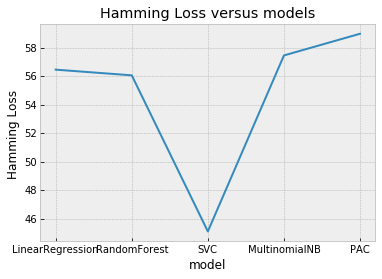

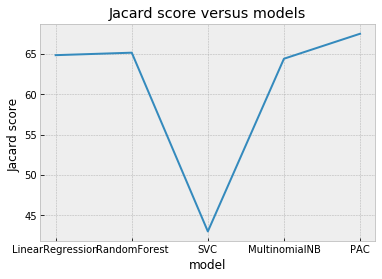

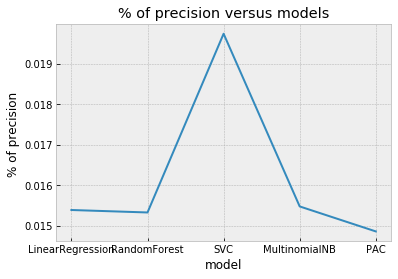

[]


In [0]:
# restore performance
J_ls = []
H_ls = []
A_ls = []
M_ls=[]

# train model accourding to classifier list
for classifier in clf_ls:
    clf = OneVsRestClassifier(classifier)
    if (classifier == clf_xg or classifier == clf_xgRF):
        clf.fit(X_train.tocsc(),y_train)
        pred_prob = clf.predict_proba(X_test.tocsc())
        pred = clf.predict(X_test.tocsc())
        Hloss, acc, Jscore = print_score(classifier, pred)
        J_ls.append(Jscore)
        H_ls.append(Hloss)
        A_ls.append(acc)
    else:
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        Hloss, acc, Jscore = print_score(classifier, pred)
        J_ls.append(Jscore)
        H_ls.append(Hloss)
        A_ls.append(acc)

    # plot performance of each model
    P_ls = [J_ls,A_ls,H_ls]

plot_performance(P_ls)
    
    

2.2.4 Grid Search

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] Lsvc__estimator__C=0.8 ..........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............. Lsvc__estimator__C=0.8, score=54.496, total=   4.8s
[CV] Lsvc__estimator__C=0.8 ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ............. Lsvc__estimator__C=0.8, score=54.883, total=   4.8s
[CV] Lsvc__estimator__C=0.8 ..........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s


[CV] ............. Lsvc__estimator__C=0.8, score=54.386, total=   4.9s
[CV] Lsvc__estimator__C=0.8 ..........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.5s remaining:    0.0s


[CV] ............. Lsvc__estimator__C=0.8, score=55.103, total=   5.0s
[CV] Lsvc__estimator__C=0.8 ..........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.5s remaining:    0.0s


[CV] ............. Lsvc__estimator__C=0.8, score=54.390, total=   5.0s
[CV] Lsvc__estimator__C=0.8444444444444444 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.5s remaining:    0.0s


[CV]  Lsvc__estimator__C=0.8444444444444444, score=54.486, total=   4.8s
[CV] Lsvc__estimator__C=0.8444444444444444 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   29.3s remaining:    0.0s


[CV]  Lsvc__estimator__C=0.8444444444444444, score=54.887, total=   4.7s
[CV] Lsvc__estimator__C=0.8444444444444444 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   34.0s remaining:    0.0s


[CV]  Lsvc__estimator__C=0.8444444444444444, score=54.402, total=   4.8s
[CV] Lsvc__estimator__C=0.8444444444444444 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   38.8s remaining:    0.0s


[CV]  Lsvc__estimator__C=0.8444444444444444, score=55.095, total=   4.7s
[CV] Lsvc__estimator__C=0.8444444444444444 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   43.5s remaining:    0.0s


[CV]  Lsvc__estimator__C=0.8444444444444444, score=54.299, total=   4.8s
[CV] Lsvc__estimator__C=0.888888888888889 ............................
[CV]  Lsvc__estimator__C=0.888888888888889, score=54.452, total=   4.7s
[CV] Lsvc__estimator__C=0.888888888888889 ............................
[CV]  Lsvc__estimator__C=0.888888888888889, score=54.881, total=   4.6s
[CV] Lsvc__estimator__C=0.888888888888889 ............................
[CV]  Lsvc__estimator__C=0.888888888888889, score=54.385, total=   4.8s
[CV] Lsvc__estimator__C=0.888888888888889 ............................
[CV]  Lsvc__estimator__C=0.888888888888889, score=55.170, total=   4.7s
[CV] Lsvc__estimator__C=0.888888888888889 ............................
[CV]  Lsvc__estimator__C=0.888888888888889, score=54.315, total=   4.6s
[CV] Lsvc__estimator__C=0.9333333333333333 ...........................
[CV]  Lsvc__estimator__C=0.9333333333333333, score=54.413, total=   4.8s
[CV] Lsvc__estimator__C=0.9333333333333333 .........................

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.4min finished


Best score: 54.708
Best parameters set:
	Lsvc__estimator__C: 0.9777777777777777


NameError: ignored

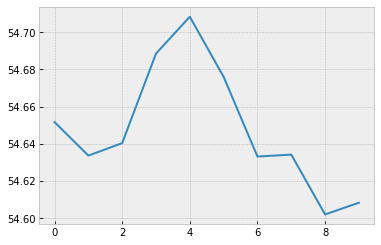

In [0]:
# """
# Chosen Parameters:
#   LinearSVC: C=1, penalty=l1


# """

# Define score
jacard_scorer = metrics.make_scorer(avg_jacard, needs_proba=False)
Loss_score = metrics.make_scorer(hamming_loss_percent, greater_is_better=False, needs_proba=False)
score_ls = [jacard_scorer,]

# define pipeline 
# Lsvc = OneVsRestClassifier(LinearSVC())
# lr = OneVsRestClassifier(LogisticRegression())

clf = pipeline.Pipeline([('Lsvc', OneVsRestClassifier(clf_Lsvc))])

# define param grid
param_grid = {'Lsvc__estimator__C': np.linspace(0.8,1.2,10),}
        # 'Lsvc__estimator__penalty': ['l1', 'l2']}

        # 'lr__C': [0.8, 1.0, 1.2], 
        # 'lr__penalty': ['l1', 'l2']

# Initialize Grid Search
SVC_search_result = []
for score in score_ls:
  # Re-split dataset into train and test(80/20)
  X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.5, random_state = 1)
  model = model_selection.GridSearchCV(estimator=clf, param_grid=param_grid, scoring=score,
                  verbose=10, cv=5)

  # Fit model
  model.fit(X_train, y_train)

  print("Best score: %0.3f" % model.best_score_)
  print("Best parameters set:")
  best_parameters = model.best_estimator_.get_params()
  for param_name in sorted(param_grid.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

  SVC_search_result.append(model.cv_results_)



Text(0.5, 1.0, 'Jaccard score versus learning rate on SVC')

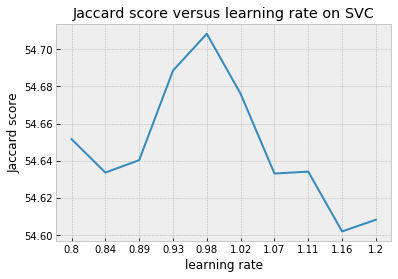

In [0]:
scale_ls = range(10)
lr_ls = np.around(np.linspace(0.8,1.2,10),2)

plt.plot(SVC_search_result[0].get('mean_test_score'))
plt.xticks(scale_ls, lr_ls)
plt.xlabel('learning rate')
plt.ylabel('Jaccard score')
plt.title('Jaccard score versus learning rate on SVC')

In [0]:
# """
# Chosen Parameters:
#   LinearRegression: C=1, penalty=l1

# """

# Define score
jacard_scorer = metrics.make_scorer(avg_jacard, needs_proba=False)
Loss_score = metrics.make_scorer(hamming_loss_percent, greater_is_better=False, needs_proba=False)
score_ls = [jacard_scorer,]

# define pipeline 
# Lsvc = OneVsRestClassifier(LinearSVC())
# lr = OneVsRestClassifier(LogisticRegression())

clf = pipeline.Pipeline([('Lr', OneVsRestClassifier(clf_logistic))])

# define param grid
param_grid = {'Lr__estimator__C': np.linspace(2,6,10),}
        # 'Lr__estimator__penalty': ['l1', 'l2']}

# Initialize Grid Search
Lr_search_result = []
for score in score_ls:
  # Re-split dataset into train and test(80/20)
  X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.5, random_state = 1)
  model = model_selection.GridSearchCV(estimator=clf, param_grid=param_grid, scoring=score,
                  verbose=10, cv=5)

  # Fit model
  model.fit(X_train, y_train)

  print("Best score: %0.3f" % model.best_score_)
  print("Best parameters set:")
  best_parameters = model.best_estimator_.get_params()
  for param_name in sorted(param_grid.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

  Lr_search_result.append(model.cv_results_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] Lr__estimator__C=2.0 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... Lr__estimator__C=2.0, score=54.644, total=  20.4s
[CV] Lr__estimator__C=2.0 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.4s remaining:    0.0s


[CV] ............... Lr__estimator__C=2.0, score=55.168, total=  19.7s
[CV] Lr__estimator__C=2.0 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.0s remaining:    0.0s


[CV] ............... Lr__estimator__C=2.0, score=54.867, total=  20.2s
[CV] Lr__estimator__C=2.0 ............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[CV] ............... Lr__estimator__C=2.0, score=55.611, total=  19.8s
[CV] Lr__estimator__C=2.0 ............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[CV] ............... Lr__estimator__C=2.0, score=54.603, total=  19.8s
[CV] Lr__estimator__C=2.4444444444444446 .............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s


[CV]  Lr__estimator__C=2.4444444444444446, score=55.043, total=  22.7s
[CV] Lr__estimator__C=2.4444444444444446 .............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.0min remaining:    0.0s


[CV]  Lr__estimator__C=2.4444444444444446, score=55.423, total=  22.9s
[CV] Lr__estimator__C=2.4444444444444446 .............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.4min remaining:    0.0s


[CV]  Lr__estimator__C=2.4444444444444446, score=55.326, total=  23.2s
[CV] Lr__estimator__C=2.4444444444444446 .............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.8min remaining:    0.0s


[CV]  Lr__estimator__C=2.4444444444444446, score=55.850, total=  23.8s
[CV] Lr__estimator__C=2.4444444444444446 .............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.2min remaining:    0.0s


[CV]  Lr__estimator__C=2.4444444444444446, score=54.945, total=  23.7s
[CV] Lr__estimator__C=2.888888888888889 ..............................
[CV] . Lr__estimator__C=2.888888888888889, score=55.026, total=  26.1s
[CV] Lr__estimator__C=2.888888888888889 ..............................
[CV] . Lr__estimator__C=2.888888888888889, score=55.585, total=  25.7s
[CV] Lr__estimator__C=2.888888888888889 ..............................
[CV] . Lr__estimator__C=2.888888888888889, score=55.553, total=  25.8s
[CV] Lr__estimator__C=2.888888888888889 ..............................
[CV] . Lr__estimator__C=2.888888888888889, score=55.908, total=  26.9s
[CV] Lr__estimator__C=2.888888888888889 ..............................
[CV] . Lr__estimator__C=2.888888888888889, score=55.276, total=  25.8s
[CV] Lr__estimator__C=3.333333333333333 ..............................
[CV] . Lr__estimator__C=3.333333333333333, score=55.196, total=  28.8s
[CV] Lr__estimator__C=3.333333333333333 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 27.3min finished


Best score: 55.610
Best parameters set:
	Lr__estimator__C: 3.7777777777777777


Text(0.5, 1.0, 'Jaccard score versus learning rate on LinearRegression')

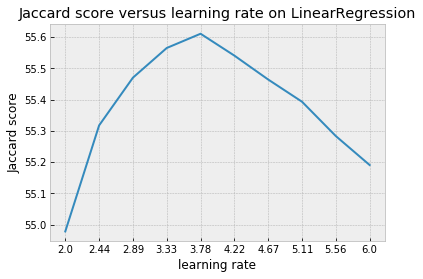

In [0]:
scale_ls = range(10)
lr_ls = np.around(np.linspace(2,6,10),2)

plt.plot(Lr_search_result[0].get('mean_test_score'))
plt.xticks(scale_ls, lr_ls)
plt.xlabel('learning rate')
plt.ylabel('Jaccard score')
plt.title('Jaccard score versus learning rate on LinearRegression')

In [0]:
"""
Chosen Parameters:
  PassiveAggressiveClassifier: C=0.1, penalty=hinge

"""

# Define score
jacard_scorer = metrics.make_scorer(avg_jacard, needs_proba=False)
Loss_score = metrics.make_scorer(hamming_loss_percent, greater_is_better=False, needs_proba=False)
score_ls = [jacard_scorer,]

# define pipeline 
# Lsvc = OneVsRestClassifier(LinearSVC())
# lr = OneVsRestClassifier(LogisticRegression())

clf = pipeline.Pipeline([('pac', OneVsRestClassifier(clf_pac))])
print(clf.get_params().keys())

# define param grid
param_grid = {'pac__estimator__C': np.linspace(0.08,0.3,10),}
        # 'pac__estimator__loss': ['hinge', 'squared_hinge']}

# Initialize Grid Search
search_result = []
for score in score_ls:
  # Re-split dataset into train and test(80/20)
  X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.5, random_state = 1)
  model = model_selection.GridSearchCV(estimator=clf, param_grid=param_grid, scoring=score,
                  verbose=10, cv=5)

  # Fit model
  model.fit(X_train, y_train)

  print("Best score: %0.3f" % model.best_score_)
  print("Best parameters set:")
  best_parameters = model.best_estimator_.get_params()
  for param_name in sorted(param_grid.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

  search_result.append(model.cv_results_)

dict_keys(['memory', 'steps', 'verbose', 'pac', 'pac__estimator__C', 'pac__estimator__average', 'pac__estimator__class_weight', 'pac__estimator__early_stopping', 'pac__estimator__fit_intercept', 'pac__estimator__loss', 'pac__estimator__max_iter', 'pac__estimator__n_iter_no_change', 'pac__estimator__n_jobs', 'pac__estimator__random_state', 'pac__estimator__shuffle', 'pac__estimator__tol', 'pac__estimator__validation_fraction', 'pac__estimator__verbose', 'pac__estimator__warm_start', 'pac__estimator', 'pac__n_jobs'])
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] pac__estimator__C=0.08 ..........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............. pac__estimator__C=0.08, score=56.027, total=   4.5s
[CV] pac__estimator__C=0.08 ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV] ............. pac__estimator__C=0.08, score=57.297, total=   3.9s
[CV] pac__estimator__C=0.08 ..........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s


[CV] ............. pac__estimator__C=0.08, score=56.493, total=   3.7s
[CV] pac__estimator__C=0.08 ..........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s


[CV] ............. pac__estimator__C=0.08, score=56.701, total=   4.3s
[CV] pac__estimator__C=0.08 ..........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.4s remaining:    0.0s


[CV] ............. pac__estimator__C=0.08, score=56.387, total=   4.2s
[CV] pac__estimator__C=0.10444444444444445 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.5s remaining:    0.0s


[CV]  pac__estimator__C=0.10444444444444445, score=56.707, total=   3.8s
[CV] pac__estimator__C=0.10444444444444445 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   24.4s remaining:    0.0s


[CV]  pac__estimator__C=0.10444444444444445, score=57.042, total=   4.7s
[CV] pac__estimator__C=0.10444444444444445 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   29.1s remaining:    0.0s


[CV]  pac__estimator__C=0.10444444444444445, score=56.711, total=   4.4s
[CV] pac__estimator__C=0.10444444444444445 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   33.5s remaining:    0.0s


[CV]  pac__estimator__C=0.10444444444444445, score=57.262, total=   4.5s
[CV] pac__estimator__C=0.10444444444444445 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   38.0s remaining:    0.0s


[CV]  pac__estimator__C=0.10444444444444445, score=56.642, total=   4.4s
[CV] pac__estimator__C=0.1288888888888889 ............................
[CV]  pac__estimator__C=0.1288888888888889, score=56.000, total=   4.4s
[CV] pac__estimator__C=0.1288888888888889 ............................
[CV]  pac__estimator__C=0.1288888888888889, score=57.155, total=   4.8s
[CV] pac__estimator__C=0.1288888888888889 ............................
[CV]  pac__estimator__C=0.1288888888888889, score=56.621, total=   4.9s
[CV] pac__estimator__C=0.1288888888888889 ............................
[CV]  pac__estimator__C=0.1288888888888889, score=56.928, total=   4.3s
[CV] pac__estimator__C=0.1288888888888889 ............................
[CV]  pac__estimator__C=0.1288888888888889, score=56.779, total=   4.4s
[CV] pac__estimator__C=0.15333333333333332 ...........................
[CV]  pac__estimator__C=0.15333333333333332, score=56.203, total=   5.0s
[CV] pac__estimator__C=0.15333333333333332 .........................

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.0min finished


Best score: 56.873
Best parameters set:
	pac__estimator__C: 0.10444444444444445


Text(0.5, 1.0, 'Jaccard score versus learning rate on PAC')

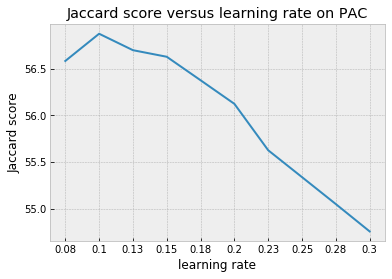

In [0]:
scale_ls = range(10)
np.set_printoptions(precision=3)
lr_ls = np.around(np.linspace(0.08,0.3,10),2)


plt.plot(search_result[0].get('mean_test_score'))
plt.xticks(scale_ls, lr_ls)
plt.xlabel('learning rate')
plt.ylabel('Jaccard score')
plt.title('Jaccard score versus learning rate on PAC')

In [0]:
# """
# Chosen Parameters:
#   XgboostRFClassifier: C=0.1, penalty=hinge

# """

# Define score
jacard_scorer = metrics.make_scorer(avg_jacard, needs_proba=False)
Loss_score = metrics.make_scorer(hamming_loss_percent, greater_is_better=False, needs_proba=False)
score_ls = [jacard_scorer]

# define pipeline 
clf = pipeline.Pipeline([('xgrf', OneVsRestClassifier(clf_xgRF))])
print(clf.get_params().keys())

# define param grid
param_grid = {'xgrf__estimator__learning_rate': [0.01, 0.1, 0.2],
        'xgrf__estimator__max_depth': [3, 6, 9]}
        # 'xgrf__estimator__n_estimator': [100, 200, 300]}
        # 'xgrf__estimator__gamma': [0, 0.01, 0.1, 1],
        # 'xgrf__estimator__min_child_weight': [1, 3, 5],
        # 'xgrf__estimator__reg_alpha': [0, 0.01, 0.1, 1]}
        # 'xgrf__estimator__reg_lambda': [3, 5, 7, 9]}

# Initialize Grid Search
xgb_search_result = []
for score in score_ls:
  # Re-split dataset into train and test(80/20)
  X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.9, random_state = 1)
  model = model_selection.GridSearchCV(estimator=clf, param_grid=param_grid, scoring=score,
                  verbose=10, cv=5)

  # Fit model
  model.fit(X_train, y_train)

  print("Best score: %0.3f" % model.best_score_)
  print("Best parameters set:")
  best_parameters = model.best_estimator_.get_params()
  for param_name in sorted(param_grid.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

  xgb_search_result.append(model.cv_results_)

dict_keys(['memory', 'steps', 'verbose', 'xgrf', 'xgrf__estimator__base_score', 'xgrf__estimator__colsample_bylevel', 'xgrf__estimator__colsample_bynode', 'xgrf__estimator__colsample_bytree', 'xgrf__estimator__gamma', 'xgrf__estimator__learning_rate', 'xgrf__estimator__max_delta_step', 'xgrf__estimator__max_depth', 'xgrf__estimator__min_child_weight', 'xgrf__estimator__missing', 'xgrf__estimator__n_estimators', 'xgrf__estimator__n_jobs', 'xgrf__estimator__nthread', 'xgrf__estimator__objective', 'xgrf__estimator__random_state', 'xgrf__estimator__reg_alpha', 'xgrf__estimator__reg_lambda', 'xgrf__estimator__scale_pos_weight', 'xgrf__estimator__seed', 'xgrf__estimator__silent', 'xgrf__estimator__subsample', 'xgrf__estimator__verbosity', 'xgrf__estimator__gpu_id', 'xgrf__estimator', 'xgrf__n_jobs'])
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=3, score=46.886, total= 1.2min
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=3, score=45.621, total= 1.2min
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=3, score=46.702, total= 1.2min
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=3 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.6min remaining:    0.0s


[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=3, score=45.809, total= 1.2min
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=3 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.8min remaining:    0.0s


[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=3, score=47.199, total= 1.2min
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=6 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.0min remaining:    0.0s


[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=6, score=48.220, total= 2.3min
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=6 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.2min remaining:    0.0s


[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=6, score=48.043, total= 2.3min
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=6 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 10.5min remaining:    0.0s


[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=6, score=49.191, total= 2.3min
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=6 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 12.8min remaining:    0.0s


[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=6, score=47.147, total= 2.3min
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=6 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 15.1min remaining:    0.0s


[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=6, score=49.762, total= 2.3min
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=9 
[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=9, score=49.946, total= 3.3min
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=9 
[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=9, score=49.211, total= 3.4min
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=9 
[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=9, score=49.708, total= 3.4min
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=9 
[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=9, score=48.520, total= 3.4min
[CV] xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=9 
[CV]  xgrf__estimator__learning_rate=0.01, xgrf__estimator__max_depth=9, score=50.293, total= 3.3min
[CV] xgrf__estimator__learning_rat

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 102.3min finished


Best score: 49.536
Best parameters set:
	xgrf__estimator__learning_rate: 0.01
	xgrf__estimator__max_depth: 9


{'mean_fit_time': array([ 70.971, 135.986, 200.486,  71.818, 137.269, 197.718,  70.644,
       136.607, 198.988]), 'std_fit_time': array([0.469, 1.337, 1.307, 0.984, 1.104, 1.046, 0.637, 0.663, 1.598]), 'mean_score_time': array([0.745, 0.823, 0.933, 0.74 , 0.829, 0.93 , 0.749, 0.827, 0.94 ]), 'std_score_time': array([0.01 , 0.014, 0.031, 0.005, 0.008, 0.007, 0.008, 0.014, 0.012]), 'param_xgrf__estimator__learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_xgrf__estimator__max_depth': masked_array(data=[3, 6, 9, 3, 6, 9, 3, 6, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'xgrf__estimator__learning_rate': 0.01, 'xgrf__estimator__max_depth': 3}, {'xgrf__estimator__learning_rate': 

Text(0.5, 1.0, 'Jaccard score versus parameters on random forest')

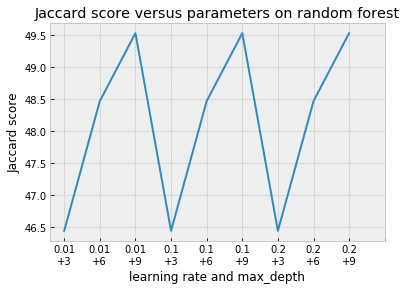

In [0]:
scale_ls = range(10)
np.set_printoptions(precision=3)

lr = ['0.01','0.1','0.2']
max_depth = ['\n+3', '\n+6', '\n+9']
pa_ls = []

for i in range(3):
  for j in range(3):
    pa_ls.append(lr[i]+max_depth[j])

lr_ls = np.around(np.linspace(0.08,0.3,10),2)
print(xgb_search_result[0])

plt.plot(xgb_search_result[0].get('mean_test_score'))
plt.xticks(scale_ls, pa_ls)
plt.xlabel('learning rate and max_depth')
plt.ylabel('Jaccard score')
plt.title('Jaccard score versus parameters on random forest')

In [0]:
# print(xgb_search_result)

Model ensemble

In [0]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold

class modelEnsemble():
  def __init__(self, model_ls, loss, accuracy, num_folds=15, lower_is_better=False):
    """
    modelEnsemble() init
    input:
     model_ls: The list of models used for ensemble, model_ls[0] is the level 0 model
     num_folds: The number of folds used for ensemble
     loss: Loss or score used to evaluate model
     lower_is_better: loss or score
    """
    # init for modelEnsemble class
    self.model_ls = model_ls
    self.num_folds = num_folds
    self.loss = loss
    self.accuracy = accuracy
    self.lower_is_better = lower_is_better
    self.levels = len(self.model_ls)

    # init for model.fit and model.predict
    self.model_save = []
    self.validation_scores = []
    self.X_train = None
    self.test = None
    self.y_train = None
    self.train_pred = None
    self.test_pred = None
    self.num_classes = None
    self.final_model = OneVsRestClassifier(model_ls[-1][0])

  
  def fit(self, X_train, y_train):
    """
    model.fit()
    input:
     X_train_ls: training data n*p
     y_train: training label n*100
    Output:
     prediction_ls: Stacking of predictions
    """

    # extract train data into class
    self.X_train = X_train
    self.y_train = y_train

    # K-folders validation
    self.num_classes = (self.y_train.shape[1])
    print("Found %d classes", self.num_classes)

    kf = KFold(n_splits=self.num_folds)

    # main loop to train models in different levels
    for level in range(self.levels-1):
      print("Begin to fit level {}".format(level))

      # Setup array to record training data pred from different levels
      self.train_pred = np.zeros((self.y_train.shape[0], len(model_ls[level])*self.y_train.shape[1]))  # n*400

      # init model save for each level
      model_level = []

      for num, model in enumerate(self.model_ls[level]):
        foldnum = 1
        model_folder = []

        for train_index, valid_index in kf.split(self.X_train, self.y_train):
          print("Training Level {} Fold # {}. Model {}".format(level, foldnum, model.__class__.__name__)) 

          # extract train and validation set        
          X_train_v, X_v, y_train_v, y_v = self.X_train[train_index, :], self.X_train[valid_index, :], y_train[train_index], y_train[valid_index]
          clf = OneVsRestClassifier(model)
          clf.fit(X_train_v, y_train_v)

          print("Predicting Level {} Fold # {}. Model {}".format(level, foldnum, model.__class__.__name__))
          y_temp = clf.predict(X_v)     
          print(self.num_classes*num , self.num_classes*(num+1))     
          self.train_pred[valid_index, self.num_classes*num : self.num_classes*(num+1)] = y_temp

          # store validation error
          Jacard_score = self.loss(y_temp, y_v)
          acc = self.accuracy(y_temp, y_v, 0.5)
          self.validation_scores.append(Jacard_score)
          print("Validation score is {}, precision is {}".format(Jacard_score, acc))
          print("// ------------------------------------------------------ //")

          foldnum += 1
          # model_folder.append(clf)
        # save model
        model_level.append(clf)
      # save model into different levels
      self.model_save.append(model_level)

    print("Begin to fit final level model .........")
    # dtrain = xgb.DMatrix(self.train_pred, label=self.y_train)
    # dtest = xgb.DMatrix(X_test, label=y_test)  
    self.final_model.fit(self.train_pred, self.y_train)  

    print("==================== Finish fitting =========================")
    

  def predict(self, X_test):
    """
    model.predict()
    input:
     X_train: test data n*p
    Output:
     pred: Predcition of final model
    """

    # extract train data into class
    self.X_test = X_test
    n,p = self.X_test.shape

    # K-folders validation
    kf = KFold(n_splits=self.num_folds)

    # main loop to train models in different levels
    for level in range(self.levels-1):
      print("Begin to predict level {}".format(level))
      
      # Setup array to record training data pred from different levels
      self.test_pred = np.zeros((self.X_test.shape[0], len(model_ls[level])*self.num_classes))

      # Convert test data to predict data
      for num in range(len(self.model_ls[level])):
        validation_scores = []
        foldnum = 1

        # for train_index, valid_index in kf.split(self.X_train[:n], self.y_train[:n]):
        #   X_test_v, X_v = self.X_test[train_index, :], self.X_test[valid_index, :]

        model = self.model_save[level][num]
        # print("Predicting Level {} Fold # {}. Model {}".format(level, foldnum, model.__class__.__name__)) 
        self.test_pred[:, self.num_classes*num : self.num_classes*(num+1)] = model.predict(self.X_test)

    print("Begin to predict final level model ........")
    pred = self.final_model.predict(self.test_pred)

    return pred



Run ensemble model

In [0]:
# -- binary multiclass --
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.1, random_state = 1) # Do 80/20 split
clf_pac1 = PassiveAggressiveClassifier(C=0.1, loss='hinge')
clf_pac3 = PassiveAggressiveClassifier(C=0.3, loss='hinge')
clf_pac2 = PassiveAggressiveClassifier(C=0.2, loss='hinge')

loss = avg_jacard
# model_ls = [[clf_logistic, clf_xgRF, clf_sgd], [clf_pac1]]
model_ls = [[clf_Lsvc, clf_logistic, clf_pac], [clf_xgRF]]
# model_ls = [[clf_sgd], [clf_mult]]

clf_ensemble = modelEnsemble(model_ls, loss, accuracy)
clf_ensemble.fit(X_train, y_train)

Found %d classes 50
Begin to fit level 0
Training Level 0 Fold # 1. Model LinearSVC
Predicting Level 0 Fold # 1. Model LinearSVC
0 50
Validation score is 55.97886593074819, precision is 0.6088310217945089
// ------------------------------------------------------ //
Training Level 0 Fold # 2. Model LinearSVC
Predicting Level 0 Fold # 2. Model LinearSVC
0 50
Validation score is 56.78743277667705, precision is 0.626379847155392
// ------------------------------------------------------ //
Training Level 0 Fold # 3. Model LinearSVC
Predicting Level 0 Fold # 3. Model LinearSVC
0 50
Validation score is 56.626568544202286, precision is 0.6243985281630342
// ------------------------------------------------------ //
Training Level 0 Fold # 4. Model LinearSVC
Predicting Level 0 Fold # 4. Model LinearSVC
0 50
Validation score is 56.370884045664695, precision is 0.6221341636003397
// ------------------------------------------------------ //
Training Level 0 Fold # 5. Model LinearSVC
Predicting Leve

In [0]:
pred = clf_ensemble.predict(X_test)
print_score(clf_ensemble, pred, y_test)

Begin to predict level 0
Begin to predict final level model ........
---
Clf:  modelEnsemble
Multiclass Log loss: 1.4164959965848446e-15
Jacard score: 59.5417232789855
Hamming loss: 0.014707880434782609
Precision: 68.22350543478261
---


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.1, random_state = 0) # Do 80/20 split
pred_last = clf_ensemble.predict(X_test[-1090])
print(pred_last)
print(y_test[-1090])


Begin to predict level 0
Begin to predict final level model ........
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
